In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

## Config

In [2]:
# trn_path = './data/input/train.csv'
tst_path = './data/input/test.csv'
id_col = 'ID'
label_col = 'item_cnt_month'

submission_path = './data/output/submission/submission.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
item_cate_df = pd.read_csv('./data/input/item_categories.csv')
item_df = pd.read_csv('./data/input/items.csv')
sales_df = pd.read_csv('./data/input/sales_train.csv')
shop_df = pd.read_csv('./data/input/shops.csv')

In [4]:
sales_df['revenue'] = sales_df['item_price'] * sales_df['item_cnt_day']
trn_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
trn_df = trn_df.rename(columns={'item_cnt_day': 'item_cnt_month'})
trn_df['ID'] = 0
trn_df['ds_type'] = 'trn'

tst_df = pd.read_csv(tst_path)
tst_df['date_block_num'] = 34
tst_df['item_cnt_month'] = 0
tst_df['ds_type'] = 'tst'

full_df = pd.concat([trn_df, tst_df])
full_df.head()

,ID,date_block_num,ds_type,item_cnt_month,item_id,shop_id
0,0,1,trn,31.0,30,0
1,0,1,trn,11.0,31,0
2,0,0,trn,6.0,32,0
3,0,1,trn,10.0,32,0
4,0,0,trn,3.0,33,0


In [5]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

## Features

In [6]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])
    
def remove_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns = [f for f in feature_columns if f not in features]

**shop_id, item_id**

In [7]:
# add_features(['shop_id', 'item_id'])

**datetime info**

In [8]:
full_df['dt_year'] = full_df['date_block_num'] // 12 + 2013
full_df['dt_month'] = full_df['date_block_num'] % 12 + 1
add_features(['dt_year', 'dt_month'])

**aggragation data**

In [9]:
def get_aggragation_feature(df, groupby_cols, agg_col):
    gb = df[df['ds_type'] == 'trn'].groupby(groupby_cols)[agg_col]
    fname_fmt = '-'.join(groupby_cols+[agg_col]) + ':%s'
    agg_df = pd.DataFrame({
            fname_fmt%'mean': gb.mean(),
            fname_fmt%'median': gb.median(),
            fname_fmt%'max': gb.max(),
            fname_fmt%'min': gb.min(),
        })
    new_df = df.join(agg_df, on=groupby_cols).fillna(0)
    return new_df, agg_df.columns.tolist()

In [10]:
groupby_cols_list = [
    ['shop_id', 'item_id'],
    ['shop_id'],
    ['item_id'],
    ['date_block_num'],
]
for groupby_cols in groupby_cols_list:
    full_df, new_feats = get_aggragation_feature(full_df, groupby_cols, 'item_cnt_month')
    add_features(new_feats)

## item_categories

Items have 84 type categories.

It's seem items almost about game host. (All Russian, I can't understand...)

In [11]:
item_cate_df.shape

(84, 2)

In [12]:
item_cate_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


## items

Total has 22170 type items.

item_id seem order by item_name.

In [13]:
item_df.shape

(22170, 3)

In [14]:
item_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


**item count by eacho item_category_id**

The highest item category is close to 5000 type items.

In [15]:
item_dist_df = item_df.groupby('item_category_id').size()

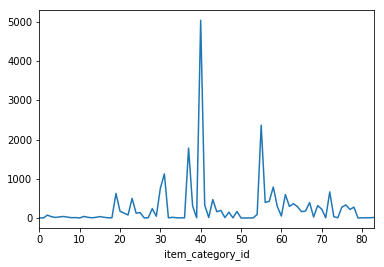

In [16]:
item_dist_df.plot()

**item count histogram to each item_category**

70+ item category have <500 items.

About 5 item category have 500~1000 items.

Rest of item category have >1000 items.

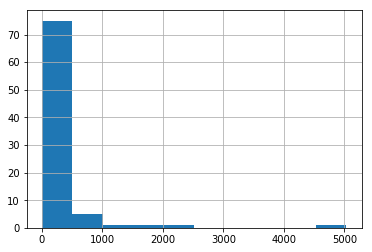

In [17]:
item_dist_df.hist()

## sales_train

sale_price and sale_count for each (shop, item, day)

item_cnt_day has negative, it means sales return.

In [18]:
sales_df.shape

(2935849, 7)

In [19]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00
6,02.01.2013,0,25,2565,549.00,1.0,549.00
7,04.01.2013,0,25,2572,239.00,1.0,239.00
8,11.01.2013,0,25,2572,299.00,1.0,299.00
9,03.01.2013,0,25,2573,299.00,3.0,897.00


### agg sales by item_id get item_price, and print item_price's describe

In [20]:
sales_item_desc_df = sales_df.groupby('item_id')['item_price'].describe()

In [21]:
sales_item_desc_df

,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
0,1.0,58.000000,NaN,58.00,58.00,58.00,58.0,58.0
1,6.0,4490.000000,0.000000,4490.00,4490.00,4490.00,4490.0,4490.0
2,2.0,58.000000,0.000000,58.00,58.00,58.00,58.0,58.0
3,2.0,79.000000,29.698485,58.00,68.50,79.00,89.5,100.0
4,1.0,58.000000,NaN,58.00,58.00,58.00,58.0,58.0
5,1.0,28.000000,NaN,28.00,28.00,28.00,28.0,28.0
6,1.0,100.000000,NaN,100.00,100.00,100.00,100.0,100.0
7,1.0,28.000000,NaN,28.00,28.00,28.00,28.0,28.0
8,2.0,58.000000,0.000000,58.00,58.00,58.00,58.0,58.0


some item only sales <5 in three years

In [22]:
cnt_dist = sales_item_desc_df['count'].value_counts().sort_index()
cnt_dist_precent = cnt_dist / cnt_dist.sum()
cnt_dist_precent.head(10)

1.0     0.108727
2.0     0.048333
3.0     0.030678
4.0     0.024763
5.0     0.021553
6.0     0.019994
7.0     0.015866
8.0     0.016875
9.0     0.013161
10.0    0.013895
Name: count, dtype: float64

**price change or not change**

In [23]:
print('item amount that price has not changed: ', (sales_item_desc_df['min'] == sales_item_desc_df['max']).sum())
print('item amount that price has changed: ', (sales_item_desc_df['min'] != sales_item_desc_df['max']).sum())

item amount that price has not changed:  5926
item amount that price has changed:  15881


**price distribution**

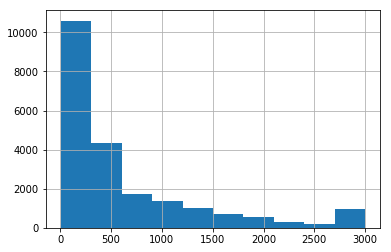

In [24]:
sales_item_desc_df['mean'].clip(0, 3000).hist()

## shops

shop name can text analyze

In [25]:
shop_df.shape

(60, 2)

In [26]:
shop_df

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9
